# Insurance complaints

Objectif : analyse exploratoire et retraitement des donnees avant l'entrainement.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from pathlib import Path

# Etape 1 — Analyse des données

In [2]:
pd.set_option('display.max_colwidth', 200)
data_path = Path('data/complaints.csv')
df = pd.read_csv(data_path)
df.head()

,Product,Consumer complaint narrative
0,Credit reporting or other personal consumer reports,"Despite multiple written requests, the unverified accounts listed below continue to report on my credit report in violation of federal law. The last letter I sent to the 3 credit bureaus was dated..."
1,Checking or savings account,"My checking account has been open with Bank of America since XXXX. My monthly balance averages over {$400.00} or more at the end of each month, and I have never bounced a check. \n\nRetired 2.5 ye..."
2,Vehicle loan or lease,"Hello, My name is XXXX XXXX I am in a 72 month contract with WESTLAKE FINANCIAL XXXX # XXXX. My car has been wrongfully repossessed and just because "" Westlake has helped me in the past '' they re..."
3,Debt collection,In XXXX I purchased a XXXX XXXX from Exter finance and received the title. I took that title and traded it in on my current car which is a XXXX XXXX XXXX XXXX. The dealership where i got my XXXX t...
4,"Credit reporting, credit repair services, or other personal consumer reports",Complaint : ( XXXX ) account # XXXXhas violated 15 U.S. Code 1692c - Communication in connection with debt collection ( b ) Communication with third parties Except as provided in section 1692b of ...


## Vue generale

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       300000 non-null  object
 1   Consumer complaint narrative  300000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


## Repartition des classes (Product)

In [4]:
class_counts = df['Product'].value_counts()
alpha_pct = (class_counts / len(df) * 100).round(2).astype(str) + "%"

class_table = pd.DataFrame({
    "count": class_counts,
    "alpha_weight_%": alpha_pct
})

class_table


,count,alpha_weight_%
Product,,
"Credit reporting, credit repair services, or other personal consumer reports",119057,39.69%
Credit reporting or other personal consumer reports,55400,18.47%
Debt collection,39443,13.15%
Mortgage,17483,5.83%
Credit card or prepaid card,15996,5.33%
Checking or savings account,14930,4.98%
Credit card,7510,2.5%
Student loan,6570,2.19%
"Money transfer, virtual currency, or money service",6213,2.07%


## Valeurs manquantes

In [5]:
df['Consumer complaint narrative'].isna().mean()

np.float64(0.0)

Il n'y a pas de valeur manquantes (0).

## Exemples par categorie (petit echantillon)

In [6]:
def sample_examples(data, n=1, random_state=42):
    return (data.dropna(subset=['Consumer complaint narrative'])
                .groupby('Product', group_keys=False)
                .apply(lambda g: g.sample(min(n, len(g)), random_state=random_state))
                [['Product', 'Consumer complaint narrative']])

sample_examples(df, n=1).head(10)

/var/folders/qz/9z30880j4h31mkt2vx6bz_mh0000gn/T/ipykernel_21091/737069070.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(n, len(g)), random_state=random_state))


,Product,Consumer complaint narrative
290060,Bank account or service,I had my transfer account to my sons account blocked and cant unblock it. After 7 months the Capital one Bank blocked me from moving money from my account to my sons ( unknown to me ) I had to be ...
37278,Checking or savings account,I am writing to formally file a complaint against Chase Bank for a series of issues that have not only caused me severe inconvenience but also appear to be retaliatory in nature. Here 's a chronol...
118031,Consumer Loan,"I was going to be late on my car payments for a lease vehicle. I asked if could get a month skipped and added to the back of the ending term agreement. I was told no, and they can only change the ..."
178907,Credit card,Around the end of XX/XX/XXXX I opened a card with Citibank and initiated balance transfer from another account with XXXX. As of XX/XX/XXXX this transfer is now on my Citibank account and I am payi...
299853,Credit card or prepaid card,Started a carecredit card for a medical device. Payed off as much as I can every month. There was {$200.00} dollars left after the promotional period. What I was told was the interest would be ove...
82136,Credit reporting,Refusing to delete account info from my credit report. XXXX has willingly deleted all the info from my report and notified XXXX credit agencies. Equifax has not and would not delete the informatio...
169218,Credit reporting or other personal consumer reports,In accordance with the Fair Credit Reporting Act. The List of accounts below has violated my federally protected consumer rights to privacy and confidentiality under 15 USC 1681.\n\nhas violated m...
124812,"Credit reporting, credit repair services, or other personal consumer reports","Hello! I sent out mails and letters to the credit bureaus about some inaccurate data on my credit report. It's been over 60 days and I never received a response from them. Section 611 ( a ), state..."
74432,Debt collection,"I'm writing to ask for the removal of late dates on disputed items from my credit report. Despite my efforts to verify inaccuracies with the information provider, there has been no response. I req..."
257487,Debt or credit management,Balance reverse from Bank of America checking account XXXX XXXX XX/XX/XXXX 2 times 2.XXXX XXXX XXXX XXXX two times XXXX XX/XX/XXXX overcharge 3.unknown charge anything after XXXX XX/XX/XXXX anyth...


# Etape 2 — Retraitement des données

## Nettoyage simple du texte
On retire les marqueurs d'anonymisation (XXXX) et les montants entre accolades, puis on normalise les espaces.

In [7]:
def clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'x{2,}', ' anon ', text)
    text = re.sub(r'\{[^}]*\}', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
df['text_clean'] = df['Consumer complaint narrative'].astype(str).apply(clean_text)
df[['Consumer complaint narrative', 'text_clean']].head()

,Consumer complaint narrative,text_clean
0,"Despite multiple written requests, the unverified accounts listed below continue to report on my credit report in violation of federal law. The last letter I sent to the 3 credit bureaus was dated...","despite multiple written requests, the unverified accounts listed below continue to report on my credit report in violation of federal law. the last letter i sent to the 3 credit bureaus was dated..."
1,"My checking account has been open with Bank of America since XXXX. My monthly balance averages over {$400.00} or more at the end of each month, and I have never bounced a check. \n\nRetired 2.5 ye...","my checking account has been open with bank of america since anon . my monthly balance averages over or more at the end of each month, and i have never bounced a check. retired 2.5 years ago on lo..."
2,"Hello, My name is XXXX XXXX I am in a 72 month contract with WESTLAKE FINANCIAL XXXX # XXXX. My car has been wrongfully repossessed and just because "" Westlake has helped me in the past '' they re...","hello, my name is anon anon i am in a 72 month contract with westlake financial anon # anon . my car has been wrongfully repossessed and just because "" westlake has helped me in the past '' they r..."
3,In XXXX I purchased a XXXX XXXX from Exter finance and received the title. I took that title and traded it in on my current car which is a XXXX XXXX XXXX XXXX. The dealership where i got my XXXX t...,in anon i purchased a anon anon from exter finance and received the title. i took that title and traded it in on my current car which is a anon anon anon anon . the dealership where i got my anon ...
4,Complaint : ( XXXX ) account # XXXXhas violated 15 U.S. Code 1692c - Communication in connection with debt collection ( b ) Communication with third parties Except as provided in section 1692b of ...,complaint : ( anon ) account # anon has violated 15 u.s. code 1692c - communication in connection with debt collection ( b ) communication with third parties except as provided in section 1692b of...


## Recherche de textes vides

In [9]:
df_clean = df[df['text_clean'].str.len() > 0].copy()
len(df), len(df_clean)

(300000, 300000)

Il n'y a pas de texte vide

## Recherche des doublons et conflits
On verifie d'abord si un meme texte nettoye est associe a plusieurs Products (conflit).

In [10]:
# Mesurer la portion de textes conflictuels (= même texte dans des catégories différentes)

conflicts = df_clean.groupby('text_clean')['Product'].nunique()
conflicting_texts = conflicts[conflicts > 1]

# Nombre de textes conflictuels (unique)
n_conflicting_texts = conflicting_texts.shape[0]

# Nombre de lignes concernées par ces conflits
n_rows_conflicting = df_clean[df_clean['text_clean'].isin(conflicting_texts.index)].shape[0]

# Portions
portion_texts = n_conflicting_texts / df_clean['text_clean'].nunique()
portion_rows = n_rows_conflicting / len(df_clean)

n_conflicting_texts, n_rows_conflicting, portion_texts, portion_rows

conflict_products = (
    df_clean[df_clean['text_clean'].isin(conflicting_texts.index)]
    .groupby('Product')
    .size()
    .sort_values(ascending=False)
)

total_per_class = df_clean['Product'].value_counts()
conflict_per_class = (
    df_clean[df_clean['text_clean'].isin(conflicting_texts.index)]
    .groupby('Product')
    .size()
)

conflict_table = (
    pd.DataFrame({
        "total": total_per_class,
        "conflicts": conflict_per_class
    })
    .fillna(0)
)

conflict_table["conflict_rate_%"] = (conflict_table["conflicts"] / conflict_table["total"] * 100).round(2)
conflict_table = conflict_table.sort_values("conflict_rate_%", ascending=False)
conflict_table


,total,conflicts,conflict_rate_%
Product,,,
Credit reporting or other personal consumer reports,55400,11033.0,19.92
Credit card,7510,673.0,8.96
"Credit reporting, credit repair services, or other personal consumer reports",119057,7674.0,6.45
Debt collection,39443,1479.0,3.75
Credit card or prepaid card,15996,447.0,2.79
Vehicle loan or lease,4745,50.0,1.05
Debt or credit management,148,1.0,0.68
"Payday loan, title loan, personal loan, or advance loan",550,3.0,0.55
Student loan,6570,15.0,0.23


## Fusion de categories (apres analyse des conflits)
On fusionne 2 "products" proches pour réduire le bruit, reduire les conflits et tester l’impact sur les performances.  
On choisit de fusionner vers l’intitulé le plus long afin de garder la granularité la plus descriptive.


In [11]:
# Catégories à fusionner
merge_map = {
    'Credit reporting or other personal consumer reports':
    'Credit reporting, credit repair services, or other personal consumer reports'
}

# fusion des catégories
df_merged = df_clean.copy()
df_merged['Product'] = df_merged['Product'].replace(merge_map)

# Recalcul des conflits apres fusion
conflicts = df_merged.groupby('text_clean')['Product'].nunique()
conflicting_texts = conflicts[conflicts > 1]


### Tableau des conflits apres fusion


In [12]:
total_per_class_merged = df_merged['Product'].value_counts()
conflict_per_class_merged = (
    df_merged[df_merged['text_clean'].isin(conflicting_texts.index)]
    .groupby('Product')
    .size()
)

conflict_table_merged = (
    pd.DataFrame({
        'total': total_per_class_merged,
        'conflicts': conflict_per_class_merged
    })
    .fillna(0)
)

conflict_table_merged['conflict_rate_%'] = (
    conflict_table_merged['conflicts'] / conflict_table_merged['total'] * 100
).round(2)
conflict_table_merged = conflict_table_merged.sort_values('conflict_rate_%', ascending=False)
conflict_table_merged


,total,conflicts,conflict_rate_%
Product,,,
Credit card,7510,673.0,8.96
Debt collection,39443,1479.0,3.75
Credit card or prepaid card,15996,447.0,2.79
"Credit reporting, credit repair services, or other personal consumer reports",174457,4575.0,2.62
Vehicle loan or lease,4745,50.0,1.05
Debt or credit management,148,1.0,0.68
"Payday loan, title loan, personal loan, or advance loan",550,3.0,0.55
Student loan,6570,15.0,0.23
"Payday loan, title loan, or personal loan",2588,6.0,0.23


## Suppression des conflits et des doublons (apres nettoyage)
Les tests montrent que conserver les doublons n’améliore pas la performance.  
On choisit donc de les supprimer pour éviter la sur‑représentation de textes identiques.

In [13]:
# Après fusion des catégories, les conflits représentent < 5% des plaintes pour chaques classes
# Pour éviter un bruit de labels, on supprime les textes conflictuels.
df_no_conflicts = df_merged[~df_merged['text_clean'].isin(conflicting_texts.index)].copy()

#On déduplique les textes afin d’éviter que des plaintes identiques soient sur‑représentées, 
# ce qui biaiserait l’apprentissage et les métriques en donnant trop de poids à des doublons.
df_dedup = df_no_conflicts.drop_duplicates(subset=['text_clean']).copy()

df_final = df_dedup.copy()


In [14]:
class_counts_final = df_final['Product'].value_counts()
class_counts_final

Product
Credit reporting, credit repair services, or other personal consumer reports    134053
Debt collection                                                                  36654
Mortgage                                                                         17470
Credit card or prepaid card                                                      15379
Checking or savings account                                                      14923
Credit card                                                                       6628
Student loan                                                                      6547
Money transfer, virtual currency, or money service                                6173
Vehicle loan or lease                                                             4691
Credit reporting                                                                  4606
Payday loan, title loan, or personal loan                                         2579
Bank account or service            

## Comptage du nombre de mot

In [15]:
word_len = df_final['text_clean'].str.split().str.len()
word_len.describe()
word_len.quantile([0.75, 0.9, 0.95])

0.75    244.0
0.90    422.0
0.95    594.0
Name: text_clean, dtype: float64

# Etape 3 — Construction du modele et optimisation

In [16]:


sns.set()


## Jeu de donnees final (df_final)

In [17]:
df_model = df_final[['Product', 'text_clean']].copy()
texts = df_model['text_clean'].astype(str)
labels = df_model['Product']
df_model.shape

(255072, 2)

## Encodage des labels et split train/val/test

In [18]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
num_classes

20

In [19]:
# stratify=y signifie que le split respecte la proportion des classes.
# 80% des données dans train, 20% restant
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# parmi les 20% restant, 50% dans test et 50% pour la validation
# soit 10% du dataset dans test et 10% pour la validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

len(X_train), len(X_val), len(X_test)

(204057, 25507, 25508)

## Vectorisation du texte

In [20]:
# limite le vocabulaire à 20 000 mots les plus fréquents (plage classique)
max_tokens = 20000
# P90 = 421, premier test avec sequence_length = 400 pour couvrir quasiment 90% des cas,
# puis second test avec sequence_length = 600 qui a permis d'augmenter le F1
sequence_length = 600

# préparation du vectorizer qui transforme chaque texte brut en une séquence d’entiers de longueur fixe
# vectorizer est une couche Keras qui doit être définie et entrainée (adapt) en amont
# chaque mot est remplacé par un nombre entier
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
    ngrams=2
)
vectorizer.adapt(X_train)

vocab_size = vectorizer.vocabulary_size()
vocab_size

20000

## Modele MLP simple
Le modèle create_model_simple correspond à la première version (MLP avec moyenne des embeddings) qui a été testée avant d’introduire la convolution 1D.

In [21]:
# la couche Embedding transforme chaque entier (mot) en un vecteur dense de taille 64 (64 float)
# la couche GlobalAveragePooling1D ait la moyenne des vecteurs de mots sur toute la séquence.
# output = un seul vecteur de taille 64 (l'ordre des mots dans la plainte ne compte pas)
# la couche Dropout limite le sur-apprentissage
def create_model_simple(num_classes, vocab_size):
    return tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorizer,
        layers.Embedding(vocab_size, 64, mask_zero=True),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="tanh"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax")
    ])

## Modele MLP avec convolution
Le modèle create_model est le modèle qui est utilisé.  
Après avoir testé un MLP simple (Embedding → moyenne → Dense) et ajusté la longueur de séquence ainsi que la régularisation, F1 restait autour de 0,70.  
J’ai donc ajouté une couche de convolution 1D, afin de capturer des motifs locaux dans le texte (bigrams/expressions), ce que la moyenne globale ne permet pas.

In [22]:
def create_model(num_classes, vocab_size):
    return tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorizer,
        layers.Embedding(vocab_size, 64),
        layers.Conv1D(64, 5, activation="relu"),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation="tanh"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])


model = create_model(num_classes=num_classes, vocab_size=vocab_size)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 600)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 600, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 596, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,311,444 (5.00 MB)

 Trainable params: 1,311,444 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

## Entrainement (early stopping pour limiter le sur-apprentissage)

In [23]:
# problème multi‑classe et les labels sont des entiers donc loss="sparse_categorical_crossentropy"
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# si val_loss ne s'améliore pas pendant 2 epoch, stop (évite le sur-apprentissage)
# le meilleur modèle est celui où la val_loss est minimale.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

X_train = X_train.astype(str).values
X_val = X_val.astype(str).values
X_test = X_test.astype(str).values

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    callbacks=[early_stop],
)

Epoch 1/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 88s 110ms/step - loss: 0.9017 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.8049
Epoch 2/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 100s 126ms/step - loss: 0.5764 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.5843 - val_sparse_categorical_accuracy: 0.8158
Epoch 3/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 90s 113ms/step - loss: 0.4790 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.5887 - val_sparse_categorical_accuracy: 0.8155
Epoch 4/10
798/798 ━━━━━━━━━━━━━━━━━━━━ 93s 117ms/step - loss: 0.3810 - sparse_categorical_accuracy: 0.8786 - val_loss: 0.6386 - val_sparse_categorical_accuracy: 0.8102


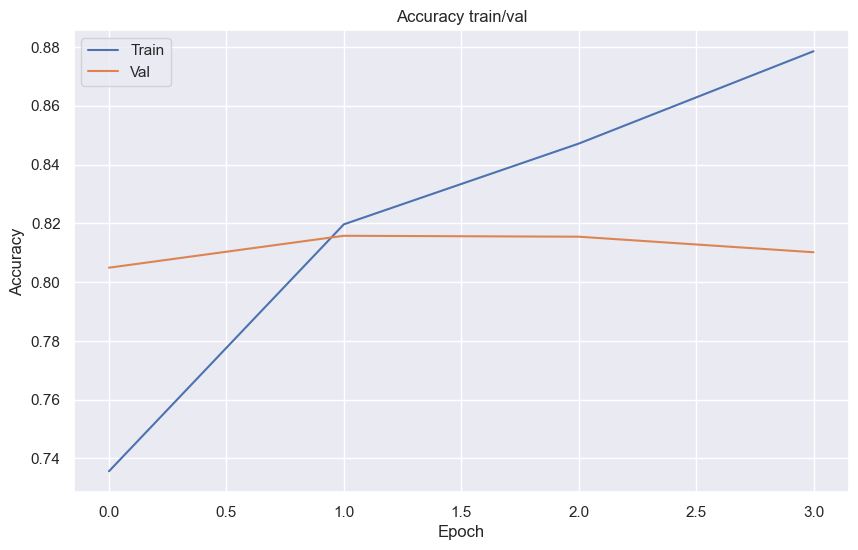

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["sparse_categorical_accuracy"], label="Train")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy train/val")
plt.legend()
plt.show()

Les courbes montrent un sur‑apprentissage rapide. L’early stopping (patience=2, restore_best_weights=True) permet d’arrêter l’entraînement au bon moment et de conserver le meilleur modèle, ce qui donne un F1 élevé.

## Evaluation (Accuracy + Weighted F1)

In [25]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print("\nClassification report:\n")

labels_all = np.arange(num_classes)

print(classification_report(
    y_test, y_pred,
    labels=labels_all,
    target_names=label_encoder.classes_,
    zero_division=0
))

798/798 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Weighted F1: 0.8004996439275022

Classification report:

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.63      0.41      0.49       216
                                                 Checking or savings account       0.69      0.82      0.75      1493
                                                               Consumer Loan       0.62      0.22      0.32       139
                                                                 Credit card       0.59      0.23      0.33       663
                                                 Credit card or prepaid card       0.61      0.70      0.65      1538
                                                            Credit reporting       0.57      0.13      0.22       460
Credit reporting, credit repair services, or other personal consumer report

On obtient un F1 score = 0.8004996439275022, ce qui est supérieur à la valeur minimale requise par l'entreprise pour valider le modèle (75%). Le modèle est donc validé pour être mis en production.

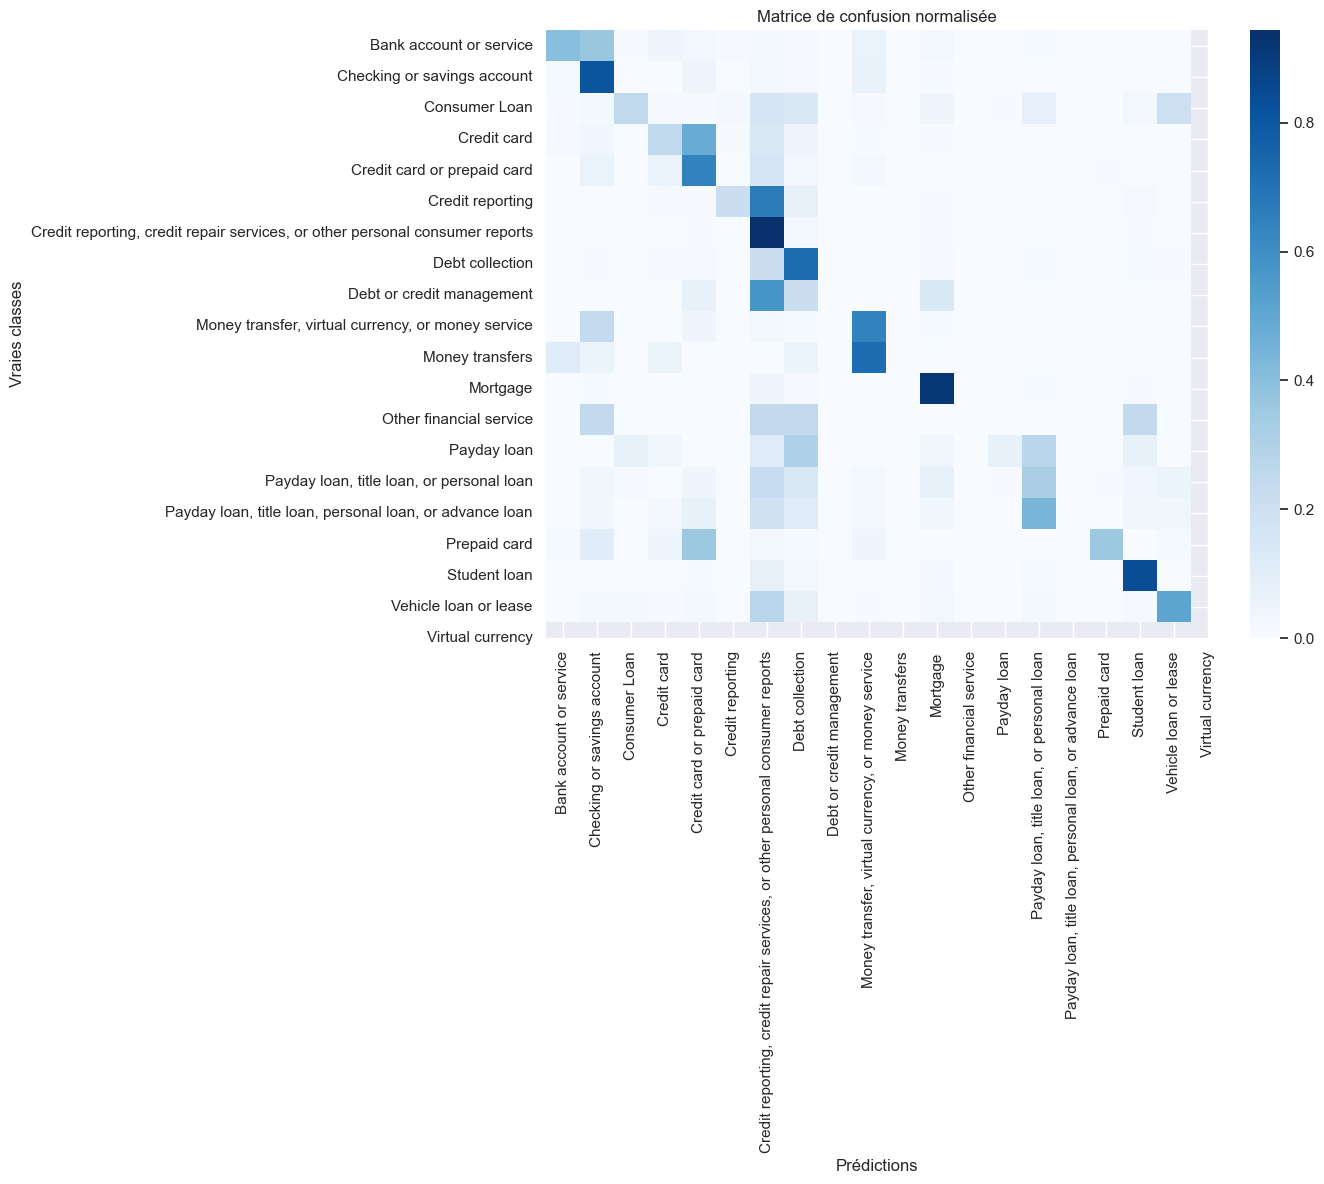

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion normalisée")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
labels = label_encoder.classes_

# Top 10 confusions (hors diagonale)
confusions = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            confusions.append((cm[i, j], labels[i], labels[j]))

for val, true_c, pred_c in sorted(confusions, reverse=True)[:10]:
    print(f"{true_c} -> {pred_c}: {val:.2%}")


Money transfers -> Money transfer, virtual currency, or money service: 72.22%
Credit reporting -> Credit reporting, credit repair services, or other personal consumer reports: 66.74%
Debt or credit management -> Credit reporting, credit repair services, or other personal consumer reports: 57.14%
Credit card -> Credit card or prepaid card: 47.96%
Payday loan, title loan, personal loan, or advance loan -> Payday loan, title loan, or personal loan: 44.44%
Bank account or service -> Checking or savings account: 36.57%
Prepaid card -> Credit card or prepaid card: 35.94%
Payday loan -> Debt collection: 30.77%
Vehicle loan or lease -> Credit reporting, credit repair services, or other personal consumer reports: 27.72%
Payday loan -> Payday loan, title loan, or personal loan: 26.92%


La matrice de confusion montre une diagonale dominante, mais les erreurs se concentrent sur des classes sémantiquement très proches. 
Ces erreurs sont cohérentes avec le vocabulaire très similaire entre ces catégories, ce qui explique que le modèle les mélange malgré un bon F1 global.